small markdown to estimate a good THETA estimate (0.08) for ~ 10 different edges and to generate
the rloc matrices for all 3 subgroups/ as well as pickled true results

In [72]:
import sys
sys.path.insert(0, '../../../helperScripts/')
from IDseqHelperFunctions import *

import scmra
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd
from datetime import datetime
import pickle
import seaborn as sns; sns.set_theme()
from matplotlib.pyplot import figure
import scmra
import itertools
import umap
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
#distribution of distances in cell space
from sklearn.metrics import pairwise_distances

import random


def write_edge_subpopulation_differences(trueEdges, recoveredEdges, nameExtension):
    #WRITE ASLSO THE SEPERATE ANALYSES INTO A TSV FILE
    objectMasterResult = open(trueEdges, "rb")
    MASTERCNR = pickle.load(objectMasterResult) #the first solution, which edges we will take

    file = open(recoveredEdges,"rb")
    resultPermSimulations = pickle.load(file)

    #get all different edges
    colsToKeep = []
    for indicator, status in MASTERCNR.vardict.items():
        if(indicator.startswith(("IDev")) and status==1):
            indSplit = indicator.split("_")
            colsToKeep.append(indSplit[1] + "_" + indSplit[2])
    #subset these column now
    resultEdgePerm = []
    for i in resultPermSimulations:
        df = i[colsToKeep]
        resultEdgePerm.append(df)
    print(colsToKeep)

    #WRITE THE EDGE DIFFERENCES BETWEEN TREATMENT/PRB AND VEHICLE INTO A TSV
    cols = ["GROUP","EDGE","VALUE"]
    dfEdgeDiff = pd.DataFrame(columns = cols)
    for i in resultEdgePerm:
        colName = i.columns
        rowNames = i.index
        for col in colName:
            for row in rowNames:
                if(not row=="vehicle"):
                    arr = [row, col, i.loc["vehicle", col] - i.loc[row, col]]
                    dfEdgeDiff = pd.concat([dfEdgeDiff, pd.DataFrame([arr], columns=["GROUP","EDGE","VALUE"])], axis=0)

    dfEdgeDiff.to_csv("../bin/edgePermutationAnalysis" + nameExtension + ".tsv", sep="\t")

    #WRITE THE EDGE DIFFERENCES FORM MASTERCNR TO A TSV
    cols = ["GROUP","EDGE","VALUE"]
    truePoint = pd.DataFrame(columns = cols)
    populations = list(MASTERCNR.rloc.keys())
    populations.remove("vehicle")
    for edge in colsToKeep:
        for pop in populations:
            toFromList = edge.split("_")
            val = MASTERCNR.rloc["vehicle"].loc[toFromList[0], toFromList[1]] - MASTERCNR.rloc[pop].loc[toFromList[0], toFromList[1]]
            arr = [pop, edge, val]
            truePoint = pd.concat([truePoint, pd.DataFrame([arr], columns=["GROUP","EDGE","VALUE"])], axis=0)

    truePoint.to_csv("../bin/edgePermutationAnalysisTrueDifferences" + nameExtension + ".tsv", sep="\t")

def shuffle_group_label(group_annot):
    keys = list(group_annot.keys())
    keyValueNumber = {}
    valueList= []
    for key in keys:
        keyValueNumber[key] = len(group_annot[key])
        valueList.append(group_annot[key])

    valueList = [item for sublist in valueList for item in sublist]

    group_annot_return = {}
    assert(len(keys) == 2)
    group_annot_return[keys[0]] = random.sample(valueList, keyValueNumber[keys[0]])
    group_annot_return[keys[1]] = list(set(valueList) - set(group_annot_return[keys[0]]))

    return(group_annot_return)

def shuffle_group_label_3labels(group_annot):
    keys = list(group_annot.keys())
    keyValueNumber = {}
    valueList= []
    for key in keys:
        keyValueNumber[key] = len(group_annot[key])
        valueList.append(group_annot[key])

    valueList = [item for sublist in valueList for item in sublist]

    group_annot_return = {}
    assert(len(keys) == 3)
    group_annot_return[keys[0]] = random.sample(valueList, keyValueNumber[keys[0]])
    group_annot_return[keys[1]] = random.sample(list(set(valueList) - set(group_annot_return[keys[0]])), keyValueNumber[keys[1]])
    listSoFar = list(set(valueList) - set(group_annot_return[keys[0]]))
    listSoFar = list(set(listSoFar) - set(group_annot_return[keys[1]]))
    group_annot_return[keys[2]] = random.sample(listSoFar, keyValueNumber[keys[2]])

    return(group_annot_return)

def get_pairwise_distances(data, method = 'cosine', seperate_z_scale = False):
    def upper_tri_indexing(A):
        m = A.shape[0]
        r,c = np.triu_indices(m,1)
        return A[r,c]


    # Z-NORMALIZE DATA
    scaledForGroup = None
    if(seperate_z_scale):
        for group in np.unique(data['treatment']):
            data_values = data[data['treatment'] == group].drop(['sample_id', 'treatment'], axis=1).values
            scaledForGroupAddon = StandardScaler().fit_transform(data_values)
            if(scaledForGroup is None):
                scaledForGroup = scaledForGroupAddon
            else:
                scaledForGroup = np.concatenate((scaledForGroup, scaledForGroupAddon), axis=0)
        data = scaledForGroup
    else:
        data_values = data.drop(['sample_id', 'treatment'], axis=1).values
        data = StandardScaler().fit_transform(data_values)

    #EGF_DATA ROW=cell columns=FEATURES (cells in rows)
    #pairwiseDistances diagonal is zero, upper triangular matrix: row=from, col=to (dsitance of cell in row 0 to cell 9 is pairwise[0,9])
    pairwiseDistances = pairwise_distances(data, metric=method)
    
    #list: only to visualize distances (other than that not an interesting data structure)
    disList = upper_tri_indexing(pairwiseDistances)

    import matplotlib.pyplot as plt
    plt.hist(disList, bins=100)
    plt.show()

    return(pairwiseDistances)



def map_string_to_ints(stringList):
    mydict={}
    i = 0
    for item in stringList:
        if(i>0 and item in mydict):
            continue
        else:    
            i = i+1
            mydict[item] = i
    k=[]
    for item in stringList:
        k.append(mydict[item])
    return(k)

def plot_graph(data, subset = None, removeIsolates = True, threshold = 0.65, method = 'cosine', protein = 'JNK-p', treatmentColor = False,
                rescaleToGroup = False, labelBYRank = False, seperate_z_scale = False, subset_data = None, edgeMap = False):

    localData = data.copy()

    adjMat = get_pairwise_distances(localData, method = method, seperate_z_scale = seperate_z_scale)
    adjMat[adjMat > threshold] = 0

    G = nx.from_numpy_array(adjMat)
    G.edges(data=True)

    #remove isolate nodes, they r not useful for graph matching
    if(removeIsolates):
        G.remove_nodes_from(list(nx.isolates(G)))
        #components smaller than...
        theshold_cluster_size = 3
        for component in list(nx.connected_components(G)):
            if len(component)<theshold_cluster_size:
                for node in component:
                    G.remove_node(node)

    #get colour scheme
    plotData = localData.copy()

    plotData = plotData.reset_index()
    index = plotData.index

    color_map = []
    if(treatmentColor):
        for node in G:
            color_map.append(plotData['treatment'][node])
        color_map = map_string_to_ints(color_map)
        minVal = 1
        maxVal = len(np.unique(color_map))
    else:
        ranksPerGroup = {}
        if(rescaleToGroup):
            for group in subset:
                ranksPerGroup[group] = ss.rankdata(plotData[plotData['treatment'] == group][protein])
                plotData.loc[plotData['cluster_id'] == group, 'rank'] = ranksPerGroup[group]
            for node in G:
                color_map.append(plotData['rank'][node]) #bcs ranks are 1-based indexed
        else:  
            for node in G:
                color_map.append(plotData[protein][node])
                #MIN and MAX values are values in range of WHOLE dataset and not only subset to see differences
        minVal = np.min(plotData[protein])
        maxVal = np.max(plotData[protein])

    if(edgeMap):
        edge_map = []
        for node in G:
            edge_map.append(len(G.edges(node)))
        minVal = np.min(edge_map)
        maxVal = np.max(edge_map)
        meanEdge = np.mean(edge_map)
        removeNodes = []
        for node in G:
            if(len(G.edges(node)) < meanEdge/4):
                removeNodes.append(node)
        #remove node and calculte edge map new
        for node in removeNodes:
            G.remove_node(node)
        edge_map = []
        for node in G:
            edge_map.append(len(G.edges(node)))
            
        color_map = edge_map

    #treamtnt col overwriting edge color, so we can reduce edges but color by treatment :D 
    if(treatmentColor):
        color_map = []
        for node in G:
            color_map.append(plotData['treatment'][node])
        color_map = map_string_to_ints(color_map)
        minVal = 1
        maxVal = len(np.unique(color_map))

    labeldict = {}
    if(labelBYRank):
        for group in subset:
            ranksPerGroup = ss.rankdata(plotData[plotData['cluster_id'] == group][protein])
            plotData.loc[plotData['cluster_id'] == group, 'rank'] = ranksPerGroup

        keys = []
        vals = []
        for node in G:
            val = plotData['rank'][node]
            strVal = ""
            #if(val < 10 or val > 150):
            if(val):
                strVal = str(val)
            vals.append(strVal)
            keys.append(node)
        labeldict = dict(zip(keys,vals))


    #LRP6_P
    #NFKB_P65_P
    #RIBOSOMAL_S6_P
    fig,ax = plt.subplots(figsize=(15, 10), dpi=80)
    pos = nx.spring_layout(G, seed=225)  # Seed for reproducible layout
    nx.draw(G, pos, with_labels=True, labels=labeldict, node_size = 350, alpha = 0.7, cmap='viridis', node_color=color_map, vmin=minVal, vmax=maxVal)
    #nx.draw(G, pos, with_labels=False, node_size = 150, alpha = 0.5, cmap=plt.cm.Reds, node_color = edge_map)

    plt.show(fig)

    return G

def plot_3d(xs, ys, zs):  
    fig,ax = plt.subplots(figsize=(15, 10), dpi=80)
    ax = fig.add_subplot(projection='3d')
    n = 100
    ax.scatter(xs, ys, zs, s=80)

    ax.set_xlabel('DIM 1')
    ax.set_ylabel('DIM 2')
    ax.set_zlabel('DIM 3')

    plt.show()

def plot_net(dfData, threshold=0.6):
    import igraph as ig
    import leidenalg as la

    adjMat = get_pairwise_distances(dfData, method = "cosine")

    adjMat[adjMat > threshold] = 0
    adjMat[adjMat > 0] = 1

    adjMat = np.asmatrix(adjMat)
    G = ig.Graph.Adjacency(adjMat)
    #make an edge list with weights for Leiden clustering
    partition = la.find_partition(G, la.ModularityVertexPartition,n_iterations=20)#, weights = weightVec)

    #label the cluster name
    partitionVec = []
    clusterDict = {}
    pNum = (0)
    for p in partition:
        if(len(p) < 5): continue
        curList = []
        for node in p:
            curList.append(str(node))
            clusterDict[node] = str(pNum)
        partitionVec.append((curList))
        pNum += 1
    tmp = dfData.copy()
    tmp.reset_index(inplace=True)
    tmp = tmp.rename(columns = {'index':'ab_name'})
    x = tmp["ab_name"].map(clusterDict)

    ig.plot(partition, vertex_label = x, seed = 1) 


normalizedDataFile = "/DATA/t.stohn/MRA/scMRA-analysis/data/processed/normalized_counts.tsv"
data = pd.read_csv(normalizedDataFile, sep='\t')

#subset the data
data = data[data["ab_name"].isin(ab_use)]
#data.head()

In [40]:
%%capture

#GENERATE PERMUTATION ANALYSIS
#permute randomly group/cell annotation

#RANDOM SHUFFLED LABELS
theta = 0.01
results = []
errorList = []
for i in range(10):
    rglob, rtot, cell_annot, tx_annot, group_annot = prepare_data(data)
    group_annot = shuffle_group_label(group_annot)

    #scd = scmra.ScData(rglob=rglob, rtot = rtot, cell_annot=cell_annot, tx_annot=tx_annot, group_annot= group_annot)
    scd = scmra.ScData(rglob=rglob, rtot = rtot, group_annot= group_annot)

    p = scmra.ScCnrProblem(scd, eta=0.0, theta=theta, prior_network = CANNONICAL_EDGES) 
    p.cpx.solve()
    s = scmra.ScCnrResult(p)
    results.append(s)

    n_res = np.size(s.residuals_complete) + np.size(s.residuals_incomplete)
    error = 0
    error += np.sum(np.array(np.square(s.residuals_complete)))/n_res
    error += np.sum(np.array(np.square(s.residuals_incomplete)))/n_res
    errorList.append(error)

#ONE TRUE EXAMPLE
trueError = 0
rglob, rtot, cell_annot, tx_annot, group_annot = prepare_data(data)
#scd = scmra.ScData(rglob=rglob, rtot = rtot, cell_annot=cell_annot, tx_annot=tx_annot, group_annot= group_annot)
scd = scmra.ScData(rglob=rglob, rtot = rtot, group_annot= group_annot)
p = scmra.ScCnrProblem(scd, eta=0.0, theta=theta, prior_network = CANNONICAL_EDGES) 
p.cpx.solve()
s = scmra.ScCnrResult(p)
trueResult = s

n_res = np.size(s.residuals_complete) + np.size(s.residuals_incomplete)
error = 0
error += np.sum(np.array(np.square(s.residuals_complete)))/n_res
error += np.sum(np.array(np.square(s.residuals_incomplete)))/n_res
trueError = error

NameError: name 'prepare_data' is not defined

SMALL PERMUTATION ANALYSIS TO CHECK HOW SIGNIFICANT THE RESULTS R

__________________________________________

write permutation pickle into a R-Studio importable table

         Error  ErrorType
1000  0.038419  trueError


/tmp/ipykernel_3314592/2818296337.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df2)


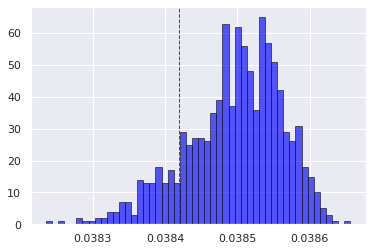

In [5]:
#PLOT THE PERMUTATION DATA

#redefine the resuklt calss to be able to load in pickle
class Result:

    trueError = None
    randomErrorList = None
    theta = None

name = "/DATA/t.stohn/MRA/scMRA-analysis/notebooks/paperAnalyses/bin/PERMUTATION_DATA_EGFR_INH.pickle"
data = pickle.load(open(name, 'rb'))

d = {"Error" : data.randomErrorList}
df = pd.DataFrame(data = d)
df["ErrorType"] = "randomError"
df2 = pd.DataFrame({"Error" : data.trueError,"ErrorType" : "trueError"}, index=[1000])
df = df.append(df2)

print(df2)

df.to_csv('../bin/permutation.txt', sep = '\t')

plt.hist(data.randomErrorList,bins=50,color='blue', edgecolor='k', alpha=0.65)
plt.axvline(data.trueError, color='red', linestyle='dashed', linewidth=1)

CLUSTER ANALYSIS (LEIDEN CLSUTERING) to find subgroups in the data, which shall be used as input for scCNR

__________________________________________________

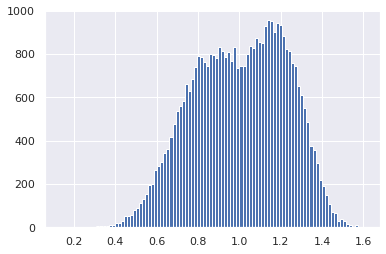

0.0126209097086948


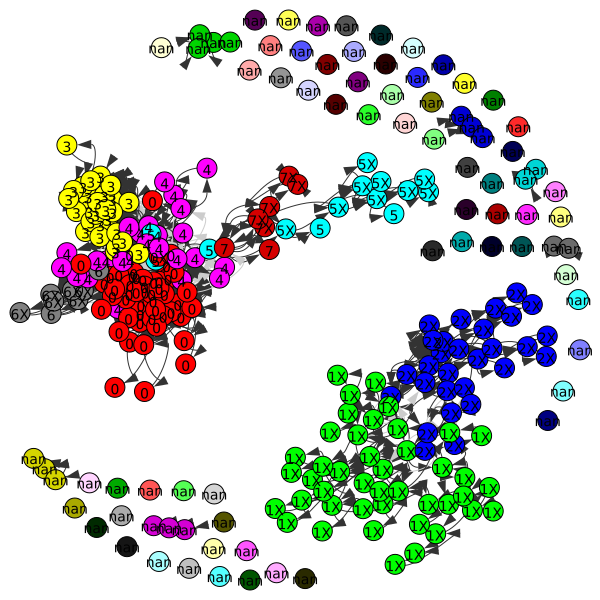

In [74]:
#LEIDEN CLSUTERING ON THIS DATA
import igraph as ig
import leidenalg as la

normalizedDataFile = "/DATA/t.stohn/MRA/scMRA-analysis/data/processed/normalized_counts.tsv"
dataForSubclustering = pd.read_csv(normalizedDataFile, sep='\t')

dfData = dataForSubclustering.pivot_table(index=['sample_id','treatment'], columns='ab_name', values='ab_count_tmm').reset_index()
#get pairwise distances zscore normalizes itself, and drops sample, and treatment column
adjMat = get_pairwise_distances(dfData, method = "cosine")

threshold = 0.54
adjMat[adjMat > threshold] = 0
weightMat = adjMat.copy()
adjMat[adjMat > 0] = 1

adjMat = np.asmatrix(adjMat)
G = ig.Graph.Adjacency(adjMat)

#make an edge list with weights for Leiden clustering
edgeList = (G.get_edgelist())
weightVec = []
for edge in edgeList:
    weightVec.append(weightMat[edge[0], edge[1]])

partition = la.find_partition(G, la.ModularityVertexPartition, n_iterations=20)#, weights = weightVec)

#labels by hand
x = dfData["PLC-g2-p"].values
print(max(x))
x[x < max(x)-0.009] = 0
x = dfData["treatment"].values
x[x=="vehicle"] = ""
x[x == "AG1478"] = "X"
treatmentLabel = x

#label the cluster name
partitionVec = []
clusterDict = {}
pNum = (0)
for p in partition:
    if(len(p) < 5): continue
    curList = []
    for node in p:
        curList.append(str(node))
        clusterDict[node] = str(pNum)
    partitionVec.append((curList))
    pNum += 1
tmp = dfData.copy()
tmp.reset_index(inplace=True)
tmp = tmp.rename(columns = {'index':'ab_name'})
x = tmp["ab_name"].map(clusterDict) + x

#map cluster IDs back to sample_ids
dfData.reset_index(inplace=True)
dfData = dfData.rename(columns = {'index':'ab_name'})
dfData["cluster"] = dfData["ab_name"].map(clusterDict)
#we removed some cells that were in a clsuter of only ONE cell
dfData = dfData.dropna()

dfData.to_csv('../../bin/GraphDataTreatedUntreated.txt', sep = '\t')

ig.plot(partition, vertex_label = x, seed = 1) 


In [50]:
print(partitionVec)

[['0', '1', '3', '4', '5', '8', '11', '15', '18', '20', '21', '22', '26', '28', '32', '35', '37', '39', '45', '48', '54', '55', '56', '60', '63', '66', '75', '78', '79', '84', '89', '90', '91', '92', '93', '96', '97', '100', '106', '107', '109', '113', '117', '119', '122', '124', '126', '127', '131', '133', '134', '135', '138', '140', '142', '143', '145', '146', '148', '150', '152', '155', '157', '158', '159', '160', '166', '169', '170', '172', '173', '176', '177', '178', '181', '184', '185', '188', '191', '194', '208', '209', '210', '211', '214', '215', '217', '219', '221', '222', '224', '225', '230', '233', '234', '235', '240', '242', '244', '245', '246', '249', '251', '252', '253', '260', '269', '278', '281'], ['6', '7', '9', '17', '23', '24', '25', '27', '29', '30', '31', '33', '34', '36', '40', '42', '43', '47', '49', '51', '52', '58', '59', '64', '67', '70', '71', '76', '77', '80', '81', '82', '87', '88', '94', '95', '101', '105', '110', '111', '112', '114', '115', '118', '120', 

Write down data table storing the clusters we want to use for scCNR: remove cells that r not
well defined (treated but not in treatment cluster)

We only keep: 

TREATED:
treated cells that r also in the cluster of treated cells (remove treated cells that r in other clsuters)

VEHICLE (pRB)

Cells in cluster 1 & 2 (removing all cells in clsuter 3,4,5)
and also all treated cells that fall into these clusters

In [65]:
#dfData stores the cluster after Leiden clustering
#data stores the raw data => join (by sample_id) the cluster annotation into the data
joinClusterFrame = dfData[["sample_id", "cluster", "treatment"]]
joinClusterFrame = joinClusterFrame.rename(columns={'treatment': 'treatmentIndicator'})

finalProcessedEGFRInhData = data[["sample_id", "treatment","ab_count_tmm","ab_name"]]
finalProcessedEGFRInhData = pd.merge(finalProcessedEGFRInhData, joinClusterFrame, left_on='sample_id', right_on='sample_id')

# write final data
finalProcessedEGFRInhData = finalProcessedEGFRInhData[((finalProcessedEGFRInhData["treatmentIndicator"] == "X") & (finalProcessedEGFRInhData["cluster"] == "1")) |
                                                      ((finalProcessedEGFRInhData["treatmentIndicator"] == "X") & (finalProcessedEGFRInhData["cluster"] == "2")) |
                                                      ((finalProcessedEGFRInhData["treatmentIndicator"] == "") & (finalProcessedEGFRInhData["cluster"] == "0")) |
                                                      ((finalProcessedEGFRInhData["treatmentIndicator"] == "") & (finalProcessedEGFRInhData["cluster"] == "3")) |
                                                      ((finalProcessedEGFRInhData["treatmentIndicator"] == "") & (finalProcessedEGFRInhData["cluster"] == "4")) ]
finalProcessedEGFRInhData['cluster'].replace({'1': 'TREATED', '2': 'TREATED', '0': 'UNTREATED', '3': 'UNTREATED','4': 'UNTREATED'},inplace=True)
finalProcessedEGFRInhData = finalProcessedEGFRInhData[["sample_id", "cluster", "ab_count_tmm", "ab_name"]]
finalProcessedEGFRInhData = finalProcessedEGFRInhData.rename(columns={'cluster': 'treatment'})

finalProcessedEGFRInhData.to_csv("./EGFRInhibitionDataProcessed_2GROUPS.tsv", sep="\t")

In [44]:
#Check that we have subsetted the right data: how many cells in each condition now...
finalProcessedEGFRInhData = pd.read_csv("./EGFRInhibitionDataProcessed_2GROUPS.tsv",sep='\t')
print(len(np.unique(finalProcessedEGFRInhData[finalProcessedEGFRInhData["treatment"] == "UNTREATED"]["sample_id"])))
print(len(np.unique(finalProcessedEGFRInhData[finalProcessedEGFRInhData["treatment"] == "TREATED"]["sample_id"])))

treated   = pd.read_csv("/DATA/t.stohn/MRA/scMRA-analysis/notebooks/paperAnalyses/4_EGFR_INHIBITOR/TREATED_VS_UNTREATED/MASTERCNR_EGFRINH_rloc_TREATED.tsv",sep='\t') 
untreated = pd.read_csv("/DATA/t.stohn/MRA/scMRA-analysis/notebooks/paperAnalyses/4_EGFR_INHIBITOR/TREATED_VS_UNTREATED/MASTERCNR_EGFRINH_rloc_UNTREATED.tsv",sep='\t')

print(treated.loc[:, "CDC2"])

103
109
0    -0.000000
1    -0.000000
2    -0.000000
3    -0.000000
4    -0.000000
5    -0.000000
6    -0.000000
7    -0.000000
8    -0.000000
9    -0.000000
10   -0.000000
11   -0.000000
12   -0.000000
13   -0.000000
14   -0.000000
15   -0.000000
16   -0.000000
17   -0.000000
18   -0.000000
19    0.068842
20   -1.000000
21   -0.000000
22   -0.000000
23   -0.000000
24   -0.000000
25   -0.000000
26   -0.000000
27   -0.000000
28   -0.000000
29   -0.000000
30   -0.000000
31   -0.000000
32   -0.000000
33   -0.000000
34   -0.000000
35   -0.000000
36   -0.000000
37   -0.000000
38   -0.000000
39   -0.000000
40   -0.042014
41   -0.000000
42   -0.000000
43   -0.000000
44   -0.000000
Name: CDC2, dtype: float64


In [45]:
edgeList = pd.DataFrame()
targetList = []
sourceList = []
duplicateList = []
for edge in G.es:
  source_vertex_id = edge.source
  target_vertex_id = edge.target
  reversedEdge = str(target_vertex_id) + "_" + str(source_vertex_id)
  if(not reversedEdge in duplicateList):
    duplicateList.append(str(source_vertex_id) + "_" + str(target_vertex_id))
    sourceList.append(source_vertex_id)    
    targetList.append(target_vertex_id)
edgeList["source"] = sourceList
edgeList["target"] = targetList

nodeLabel = pd.DataFrame()
nodeLabel["node"] = x.index
nodeLabel["cluster"] = x

edgeList.to_csv('../bin/GraphEdges.txt', sep = '\t')
nodeLabel.to_csv('../bin/GraphNodeCluster.txt', sep = '\t')


In [ ]:
#WE DO NOT KEEP THE SMALL CLUSTERS
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.verbosity = 2 

data = dfData.drop(['sample_id', 'treatment','ab_name','cluster'], axis=1)
dataTrans = StandardScaler().fit_transform(data)
data = pd.DataFrame(dataTrans, index=data.index, columns=data.columns)

print(data)

adata = sc.AnnData(data)
adata.obs['cluster'] = dfData['cluster'].apply(str).astype('category').to_numpy()
adata.obs['treatment'] = dfData['treatment']
adata.obs['sample_name'] = dfData['sample_id']       

sc.tl.rank_genes_groups(adata, 'cluster', method='wilcoxon', key_added = "wilcoxon")

##########
THETA analysis to find the right theta

FOR ALL 3 POPULATIONS: 0.1 (~ 12 diff edges)
FOR VEH-TREATED: 0.1 (also ~12 diff edges)
FOR VEH-pRB: more like 0.01

In [6]:
%%capture
#ESTIMATE THE RIGHT THETA
clusteredData = pd.read_csv("./EGFRInhibitionDataProcessed_2GROUPS.tsv", sep = "\t")

thetaRange = [0.001,0.005,  0.01,  0.02, 0.03, 0.04,  0.05,  0.07,  0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,1]
#thetaRange = [0.001,  0.01, 0.03,0.05,  0.1, 0.3, 0.5,  0.7,  0.9,2,4,6,8,10]

results = []
errorList = []
diffEdgeListTreat = []
diffEdgeListpRB = []

for theta in thetaRange:
    rglob, rtot, cell_annot, tx_annot, group_annot = prepare_data_for_EGFR_inhibition(clusteredData)
    
    #WE DO NOT WANT ANY TREATMENT ANNOTATION!!!
    #scd = scmra.ScData(rglob=rglob, rtot = rtot, cell_annot=cell_annot, tx_annot=tx_annot, group_annot= group_annot)
    scd = scmra.ScData(rglob=rglob, rtot = rtot, group_annot= group_annot)

    p = scmra.ScCnrProblem(scd, eta=0.0, theta=theta, prior_network = CANNONICAL_EDGES) 
    p.cpx.solve()
    s = scmra.ScCnrResult(p)
    results.append(s)

    n_res = np.size(s.residuals_complete) + np.size(s.residuals_incomplete)
    error = 0
    error += np.sum(np.array(np.square(s.residuals_complete)))/n_res
    error += np.sum(np.array(np.square(s.residuals_incomplete)))/n_res
    errorList.append(error)

    var_names = p.cpx.variables.get_names()
    vars_lst = [var for var in var_names if var.startswith('IDev')]
    var_vals = p.cpx.solution.pool.get_values(0, vars_lst)
    lengthIdcs = (np.count_nonzero(var_vals))
    diffEdgeListTreat.append(lengthIdcs)

    #diffMatrix = np.array(s.rloc["vehicle"]-s.rloc["vehiclepRB"])
    #diffMatrix = (diffMatrix.flatten())
    #x = [i for i, e in enumerate(diffMatrix) if e != 0]
    #diffEdgeListpRB.append(len(x))

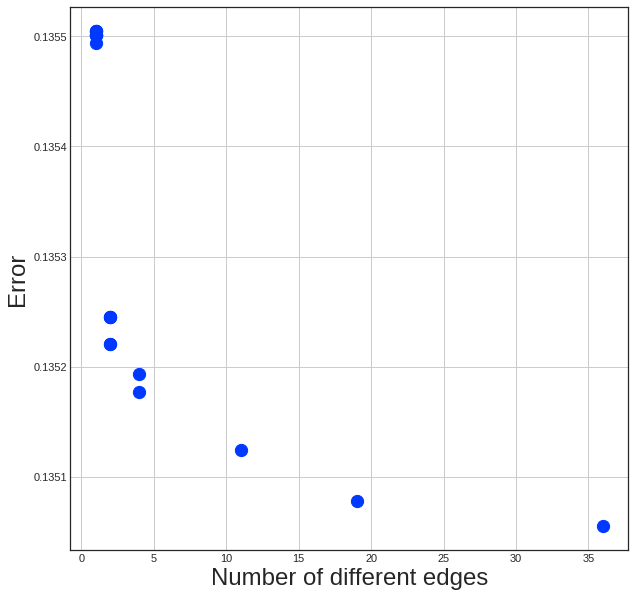

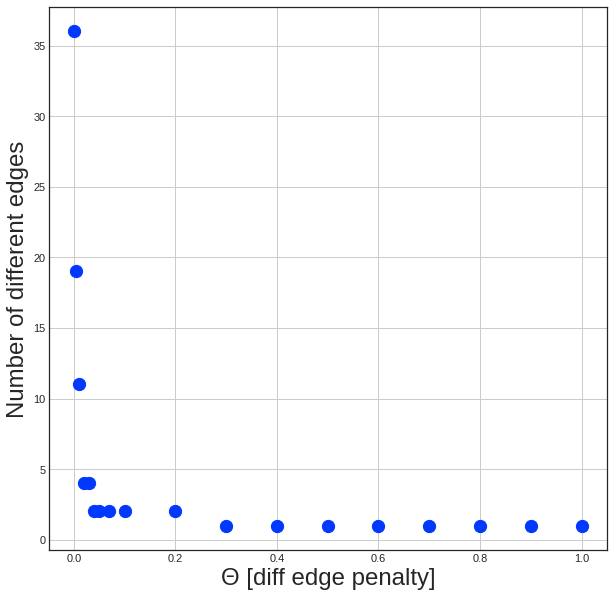

[36, 19, 11, 4, 4, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1]
[0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]


In [7]:

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    f, ax = plt.subplots(figsize=(10, 10))
    wt = ax.scatter(diffEdgeListTreat, errorList, color = "#0138FE", s = 150)
    ax.plot(ls="--", c=".3")
    plt.xlabel('Number of different edges', size = 24)
    plt.ylabel('Error', size = 24)
    plt.show()

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    f, ax = plt.subplots(figsize=(10, 10))
    wt = ax.scatter(thetaRange, diffEdgeListTreat, color = "#0138FE", s = 150)
    ax.plot(ls="--", c=".3")
    plt.xlabel('Θ [diff edge penalty]', size = 24)
    plt.ylabel('Number of different edges', size = 24)
    plt.show()

print(diffEdgeListTreat)
print(thetaRange)

GENERATE THE scCNR ANALYSIS FOR 3 SUBGROUPS, MAINLY GENERATING:

________________

1.) MASTER RLOCS FOR 3 SUBGROUPS

2.) DIFF RLOCS FOR COMAPRISONS TO VEHICLE

In [69]:
%%capture

#global scCNR parameters

THETA = 0.007

finalProcessedEGFRInhData = pd.read_csv("./EGFRInhibitionDataProcessed_2GROUPS.tsv",sep='\t')
results = []
errorList = []
rglob, rtot, cell_annot, tx_annot, group_annot = prepare_data_for_EGFR_inhibition(finalProcessedEGFRInhData)
assert(cell_annot is None)
assert(tx_annot is None)

scd = scmra.ScData(rglob=rglob, rtot = rtot, cell_annot=cell_annot, tx_annot=tx_annot, group_annot= group_annot)

p = scmra.ScCnrProblem(scd, eta=0.0, theta=THETA, prior_network = CANNONICAL_EDGES) 
p.cpx.solve()
s = scmra.ScCnrResult(p)

#STORE THE RECONSTRUCTED RLOCS
s.rloc["TREATED"].to_csv("./MASTERCNR_EGFRINH_rloc_TREATED_2GROUPS.tsv", sep = "\t")
s.rloc["UNTREATED"].to_csv("./MASTERCNR_EGFRINH_rloc_UNTREATED_2GROUPS.tsv", sep = "\t")

#STORE THE RECONSTRUCTED DIFFERENCES OF RLOCS
diffRlocEGFRInh, numDifferencesP = return_true_difference_rloc(s.rloc["UNTREATED"], s.rloc["TREATED"], s)

diffRlocEGFRInh.to_csv("./MASTERCNR_difference_rloc_EGFRInhibited_2GROUPS.tsv", sep = "\t")

#STORE THE RESULT AS PICKLE (e.g. for alter comparison to MASTERCNR error)
folder = "./"
name = "MASTERCNR_EGFRINH_CNRRESULT_2GROUPS"
pickleFile = folder + name + ".pickle"
pickle.dump(s, open(pickleFile, 'wb'))

#SOME OUTPUT JUST FOR QUALITY CHECKING

#NUMBER OF FDIFFERENT EDGES
deviatingEdgeNum = 0
for indicator, status in s.vardict.items():
    if(indicator.startswith(("IDev")) and status==1):
        deviatingEdgeNum = deviatingEdgeNum + 1
print(deviatingEdgeNum)

#THE ACTUAL ERROR SCORE
n_res = np.size(s.residuals_complete) + np.size(s.residuals_incomplete)
error = 0
error += np.sum(np.array(np.square(s.residuals_complete)))/n_res
error += np.sum(np.array(np.square(s.residuals_incomplete)))/n_res
trueError = error
print(error)

In [70]:
print(deviatingEdgeNum)

colsToKeep = []
for indicator, status in s.vardict.items():
    if(indicator.startswith(("IDev")) and status==1):
        indSplit = indicator.split("_")
        colsToKeep.append([indSplit[1], indSplit[2]])

print(colsToKeep)

12
[['RB', 'CDC2'], ['MAPKAP2', 'P38'], ['FAK', 'SRC'], ['RB', 'CDK4'], ['SMAD15', 'BMPR'], ['AKT123', 'MAPKAP2'], ['CJUN', 'JNK'], ['AKT123', 'EGFR'], ['AKT1', 'EGFR'], ['SMAD159', 'BMPR'], ['IKBA', 'AKT1'], ['CREB', 'P38']]


{'vehicle': array(['plate.1.162', 'plate.1.165', 'plate.1.174', 'plate.1.179',
       'plate.1.190', 'plate.1.191', 'plate.1.199', 'plate.1.203',
       'plate.1.212', 'plate.1.213', 'plate.1.230', 'plate.1.233',
       'plate.2.152', 'plate.2.159', 'plate.2.170', 'plate.2.173',
       'plate.2.193', 'plate.2.204', 'plate.2.211', 'plate.2.212',
       'plate.2.214', 'plate.2.224', 'plate.3.164', 'plate.3.182',
       'plate.3.187', 'plate.3.191', 'plate.3.199', 'plate.3.204',
       'plate.3.206', 'plate.3.213', 'plate.3.237', 'plate.4.162',
       'plate.4.168', 'plate.4.181', 'plate.4.187', 'plate.4.202',
       'plate.4.207', 'plate.4.210', 'plate.4.211', 'plate.4.219',
       'plate.5.157', 'plate.5.165', 'plate.5.171', 'plate.5.175',
       'plate.5.180', 'plate.5.204', 'plate.5.219', 'plate.6.169',
       'plate.6.191', 'plate.6.195', 'plate.6.199', 'plate.6.210',
       'plate.6.217', 'plate.6.219', 'plate.6.224', 'plate.6.227',
       'plate.6.229', 'plate.6.231'], dtype='<U11'

/DATA/t.stohn/MRA/scMRA-analysis/notebooks/paperAnalyses/4_EGFR_INHIBITOR/../../helperScripts/IDseqHelperFunctions.py:333: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  rglob_cnr = rglob_cnr.sum(level=0) #sum rows of same index (e.g. two ABs measure same protein)
/DATA/t.stohn/MRA/scMRA-analysis/notebooks/paperAnalyses/4_EGFR_INHIBITOR/../../helperScripts/IDseqHelperFunctions.py:342: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  rtot_cnr = rtot_cnr.sum(level=0) #sum rows of same index (e.g. two ABs measure same protein)


<AxesSubplot: xlabel='CDK4', ylabel='RB'>

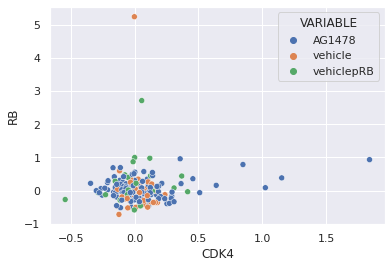

In [7]:
finalProcessedEpiDiffData = pd.read_csv("../bin/EGFRInhibitionDataProcessed.tsv",sep='\t')
rglob, rtot, cell_annot, tx_annot, group_annot = prepare_data_for_EGFR_inhibition(finalProcessedEpiDiffData)
newdict = {}
for key, value in group_annot.items():
    for string in value:
        newdict[string] = key
x=rglob.reset_index()
x = pd.melt(x, id_vars='index', value_vars=rglob.columns,
             var_name='VARIABLE', value_name='VALUE')
x.rename(columns = {'index':'PROTEIN'}, inplace = True)
x=x.pivot(index = "VARIABLE", columns='PROTEIN', values='VALUE')
x=x.reset_index()
x = x. replace({"VARIABLE": newdict})

sns.scatterplot(x="CDK4", y="RB",
              hue="VARIABLE",
              data=x)